# 1. 背景信息

策略梯度方法（policy gradient methods）是最近把深度神经网络应用在控制方面取得突破的基础，应用包括电子游戏、3D运动和围棋。但是因为策略梯度方法对步长（stepsize）的选择非常敏感，所以通过使用策略梯度方法得到好的结果是非常具有挑战性的。如果步长太小，进展就会很慢；如果步长太大信号就会被噪音盖过，或者性能就会经历灾难性的下降。它们的样本效率也常常很低，学习一个简单的任务需要百万帧的信息。

研究人员尝试了通过约束或者优化策略更新的步长，使用比如像TRPO和ACER这些方法消除这些缺陷。这些方法都有各自的取舍。ACER（actor-critic with experience replay）的性能在Atari benchmark上只比PPO好一些，但算法比PPO复杂得多，需要额外的代码来做离线更正（off-policy corrections）和一个重播缓存（a replay buffer）。TRPO（trust region policy optimization）尽管在连续控制任务中非常有用，但与共享参数的算法的兼容性并不好，这里是指在那些视觉输入非常重要的任务中策略和价值函数或是辅助损失（auxiliary losses）的参数共享，比如Atari。

# 2. PPO的简易性

我们可以用监督学习轻松地实现成本函数并在它上面使用梯度下降，而且我们很有信心在较少调参的前提下会得到很好的结果。强化学习的成功之路并没有那么明显，算法有许多难以调试的动态部分，取得较好的结果这往往需要大量调参方面的努力。PPO在实现的简易程度、样本复杂度和调参简易度上取得了相对的平衡，确保了计算单步更新时在最小化成本函数的同时保证了与之前策略的偏差也较小。

# 3. 论文摘要部分

我们提出了一系列新的强化学习的策略梯度方法，这些方法会在两个进程中交替。一个进程是在于环境的交互中取样数据，另一个进程是用随机梯度上升优化一个“代理”目标函数。传统的策略梯度方法在每个样本上进行一次梯度更新，而我们提出的新的目标函数可以进行小批量更新的多次迭代。我们的新方法叫作近端策略优化（proximal policy optimization, or PPO），它具有信赖域策略优化（trust region policy optimization, or TRPO）的一些优点，但它的实现要简单得多并且（根据实证）具有更好的样本复杂性。我们的实验在一系列基准任务上测试了PPO，这些基准任务包括了模拟的机器人运动和玩Atari游戏，并且我们的结果表明PPO的性能超过了其他实时地策略梯度方法，在整体上达到了样本复杂性、简易性和计算时间之间的平衡。

# 4. 论文引言部分

在最近几年，许多不同的使用神经网络进行函数近似的强化学习方法被提了出来。其中的佼佼者有deep Q-learning、传统策略梯度方法和信赖域/自然策略梯度方法。然而，在可扩展性（在大型模型和并行实现上）、数据高效性和可靠性（在不调参的前提下也能在不同问题上取得成功）上还存在改进空间。Q-learning（带函数近似的）在很多简单问题上都失败了并且人们对它知之甚少，传统策略梯度方法的数据利用率和可靠性都较差。信赖域策略优化（TRPO）相对比较复杂，并且与包含噪声（比如dropout）和参数共享（在策略与价值函数之间，或者与辅助任务之间）的结构不兼容。

这篇论文想要通过引入一个在使用一阶优化的前提下可以达到TRPO数据效率和可靠性的算法来改善目前的状况。我们提出了一个新的带有经裁剪的概率比的目标，这也是对策略性能的悲观估计（也就是下界）。为了优化策略，我们在用策略取样数据和用样本数据进行多次迭代之间交替。

我们的实验比较了不同版本的代理目标的性能，并且发现带有经裁剪的概率比的版本表现最好。我们也比较了PPO和其他文献中的多个算法。在连续控制任务中，PPO比我们提供的其它算法表现要好。在Atari游戏上，PPO的性能比A2C好得多，PPO在比ACER简单许多的情况下能达到相似的性能。

# 5. 论文理论部分

## 5.1. 背景知识：策略优化

### 5.1.1. 策略梯度方法

策略梯度方法通过计算策略梯度的估计值并把这个估计值输入到一个随机梯度上升算法中。最常用的梯度估计的形式是这样的

\begin{equation}
\hat{g} = \hat{\mathbb{E}}_t \left[ \nabla_{\theta} \log \pi_{\theta} (a_t \mid s_t) \hat{A}_t \right]
\end{equation}

这里的$\pi_{\theta}$是一个随机策略，$\hat{A}_t$是优势函数在$t$时刻的估计值。在这里，期望$\hat{\mathbb{E}}_t \left[ \ldots \right]$表示了在一个交替使用取样和优化算法中的有限批样本的经验平均值。具体实现的时候会使用自动微分软件，这个自动微分软件会构建一个梯度是策略梯度估计值的目标函数，而这个估计值$\hat{g}$是通过微分这个目标得到的

\begin{equation}
L^{PG}(\theta) = \hat{\mathbb{E}}_t \left[ \log \pi_{\theta} (a_t \mid s_t) \hat{A}_t \right]
\end{equation}

虽然使用相同的轨迹来来实现损失$L^{PG}$的多步优化很吸引人，但这样做并不是很合理，实践证明这种做法常常会导致策略更新过于剧烈而且效果并不好。

### 5.1.2. 信赖区方法（Trust Region Methods）

在TRPO中，最大化目标函数（也就是“代理”目标）会在策略更新幅度的限制下进行。具体就是，

\begin{split}
& \operatorname*{maximize}_{\theta} \enspace\hat{\mathbb{E}}_t \left[ \frac{\pi_{\theta} (a_t \mid s_t)}{\pi_{\theta_{old}} (a_t \mid s_t)} \hat{A}_t \right] \\
& subject \enspace to \enspace \hat{\mathbb{E}}_t \left[ KL [ \pi_{\theta_{old}} (\cdot \mid s_t), \pi_{\theta} (\cdot \mid s_t) ] \right] \leq \delta
\end{split}

在这里，$\theta_{old}$是更新前的策略参数向量。这个问题可以在对目标进行线性近似和对约束进行二次近似后用共轭梯度算法来高效地近似求解。

TRPO的理论证明实际上推荐使用惩罚项而不是约束，也就是说目标是求解无约束的优化问题

\begin{equation}
\operatorname*{maximize}_{\theta} \enspace \hat{\mathbb{E}}_t \left[ \frac{\pi_{\theta} (a_t \mid s_t)}{\pi_{\theta_{old}} (a_t \mid s_t)} \hat{A}_t - \beta KL [ \pi_{\theta_{old}} (\cdot \mid s_t), \pi_{\theta} (\cdot \mid s_t) ] \right]
\end{equation}

这里的$\beta$是一个系数。代理目标计算了状态上的KL最大值而不是平均值。代理目标在策略$\pi$的性能度量上需要有一个下界，也就是一个悲观约束界限，而这个形式满足了这个要求。因为选择单一$\beta$值并在不同问题上都取得良好性能是非常困难的，就算在同一个问题的学习过程中系统特性也可能会发生改变，所以TRPO使用了硬约束而不是惩罚项。因此，为了实现我们使用一阶算法来达到与TRPO类似的单调改进性能的目标，实验结果显示简单地选择固定惩罚系数$\beta$并用SGD来优化带惩罚项的目标函数是不够的，我们需要进行额外的修改。

### 5.2. 经裁剪的代理目标（Clipped Surrogate Objective）

让我们用$r_t (\theta)$来表示概率比$r_t (\theta) = \frac{\pi_{\theta} (a_t \mid s_t)}{\pi_{\theta_{old}}}$，在这里$r(\theta_{old})=1$。TRPO最大化了“代理”目标

\begin{equation}
L^{CPI}(\theta) = \hat{\mathbb{E}}_t \left[ \frac{\pi_{\theta} (a_t \mid s_t)}{\pi_{\theta_{old}} (a_t \mid s_t)} \hat{A}_t \right] = \hat{\mathbb{E}}_t \left[ r_t (\theta) \hat{A}_t \right]
\end{equation}

上标$CPI$表示了保守策略迭代（conservative policy iteration）。没有这个约束的话，对$L^{CPI}$进行最大化会引起过大的策略更新。因此，我们现在来考虑如何修改这个目标，来惩罚使$r_t (\theta)$远离$1$的策略改变。

我们提出的主要目标如下

\begin{equation}
L^{CLIP} (\theta) = \hat{\mathbb{E}}_t \left[ min(r_t (\theta) \hat{A}_t, clip(r_t (\theta), 1-\epsilon, 1+ \epsilon) \hat{A}_t) \right]
\end{equation}

这里的$\epsilon$是一个超参数，比如说$\epsilon = 0.2$。使用这个目标的动机如下。$min$函数中的第一项是$L^{CPI}$。第二项，也就是$clip(r_t (\theta), 1-\epsilon,1+\epsilon)\hat{A}_t$，通过裁剪概率比修改了代理目标，它移除了$r_t$在区间$\left[ 1-\epsilon, 1+\epsilon \right]$外的激励。最后，我们取裁剪前和裁剪后目标中的最小值，以保证最终目标是未裁剪目标的一个下界（也就是悲观约束界限）。在这个方案下，我们在使目标改进时忽略概率比的改变，但在目标变差时会考虑概率比的改变。注意这里在$r=1$时$L^{CLIP} (\theta) = L^{CPI} (\theta)$，但它们在$\theta$远离$\theta_{old}$时会变得非常不同。下图画出了$L^{CLIP}$中的其中一项（也就是在某一$t$时）。注意这里的概率比$r$会根据优势项的正负来在$1-\epsilon$或$1+\epsilon$会进行裁剪。

<img src="files/figures/clip_in_surrogate_function.png" style="width: 600px;" />

代理函数$L^{CLIP}$是概率比$r$的函数，上图展示了$L^{CLIP}$中的一项（在$t$时刻时）。左图是正优势的情况，有图是负优势的情况。两幅图中的红点表示了优化的起始点位置，也就是$r=1$时的位置。这里值得注意的是$L^{CLIP}$是许多项的累加和。

下图提供了关于代理目标$L^{CLIP}$的直观感受。它展示了我们在连续控制问题上使用近端策略优化的过程中，当我们在策略更新方向上插值时多个目标是怎样变化的。我们可以看到$L^{CLIP}$是$L^{CPI}$在给过大策略更新惩罚时的一个下界。

<img src="files/figures/surrogate_objectives.png" style="width: 600px;" />

代理目标，它是当我们在初始策略参数$\theta_{old}$中插值并且更新后（也就是在一次PPO迭代后）的策略参数。更新后的策略与初始策略的KL散度大约是$0.02$，这个值也就是$L^{CLIP}$的最大值。上图对应了在Hopper-v1问题上的第一次策略更新。

### 5.3. 自适应KL惩罚系数

我们可以使用其它方法来替代经裁剪的代理目标方法，或者除此之外开一在KL散度上使用惩罚项，这种方法会调整惩罚系数来让我们在每次策略更新时都能取得KL散度的某个目标值$d_{targ}$。在我们的研究中，KL惩罚方法的效果没有经裁剪的代理目标方法好，但因为它是一种重要的基准，所以在这里我们还是会提到它。

在这个算法最简单的实例中，我们在每次的策略更新中都使用了如下的步骤：

- 使用小批量SGD的多次迭代，对KL惩罚后的目标进行优化

\begin{equation}
L^{KLPEN} (\theta) = \hat{\mathbb{E}}_t \left[ \frac{\pi_{\theta} (a_t \mid s_t)}{\pi_{\theta_{old}} (a_t \mid s_t)} \hat{A}_t - \beta KL [ \pi_{\theta_{old}} (\cdot \mid s_t), \pi_{\theta} (\cdot \mid s_t) ] \right]
\end{equation}

- 计算$d=\hat{\mathbb{E}}_t \left[ KL [ \pi_{\theta_{old}} (\cdot \mid s_t), \pi_{\theta} (\cdot \mid s_t) ] \right]$
    - 如果$d<\frac{d_{targ}}{1.5}$，就使$\beta \leftarrow \frac{\beta}{2}$
    - 如果$d>1.5d_{targ}$，就使$\beta \leftarrow 2\beta$

更新后的$\beta$会被用在下一次策略更新中。在这个方案下，我们会偶尔遇到KL散度与$d_{targ}$非常不同的策略更新情况，但这种情况非常少见，并且$\beta$会很快被调整过来。这里的参数$1.5$和$2$都是试验性的取值，但算法对它们的取值并不十分敏感。$\beta$的初始值是另外一个超参数，但在实际应用中并不重要，因为算法会很快对其进行调整。

### 5.4. 算法

代理损失可以用稍作修改的经典策略梯度实现来进行计算和微分。在使用自动微分的实现中，我们只是简单地构造损失$L^{CLIP}$或$L^{KLPEN}$而不是$L^{PG}$，并且在目标上进行随机梯度上升的多步更新。

大多计算缩减方差优势函数估值的技巧都会用到学到的状态价值函数$V(s)$。比如说泛化优势估值法，或是有限界估值法。如果要使用在策略和价值函数之间共享参数的神经网络结构的话，我们必须使用结合策略代理和损失函数的误差项。我们可以在这个目标上增加一个额外熵来确保充足的探索。结合这些项，我们可以得到下面这个在每次迭代都会被（近似）最大化的目标：

\begin{equation}
L_t^{CLIP+VF+S} (\theta) = \hat{\mathbb{E}}_t \left[ L_t^{CLIP} (\theta) - c_1 L_t^{VF} (\theta) + c_2 S[\pi_{\theta}] (s_t) \right]
\end{equation}

在这里$c_1$和$c_2$是系数，$S$表示了额外熵，$L_t^{VF}$是一个平方误差损失$(V_{\theta}(s_t) - V_t^{targ})^2$。

策略梯度有一种非常适合递归神经网络的实现形式，它先运行$T$步策略（这里的$T$比回合长度短得多），然后用收集到的样本进行更新。这种实现形式不要一个不会超过$T$步的优势估值器。估值器的形式可以是

\begin{equation}
\hat{A}_t = - V(s_t) + r_t + \gamma r_{t+1}+\ldots + \gamma^{T-t+1} r_{T-1} + \gamma^{T-t} V(s_T)
\end{equation}

这里的$t$是在给定的$[0,T]$这个轨迹段内的时间标记。我们可以让这个选择更加一般化，我们可以使用泛化优势估值的一个裁剪版本，也就是上式中$\lambda = 1$的情况

\begin{split}
& \hat{A}_t = \delta_t + (\gamma \lambda)\delta_{t+1} + \ldots + (\gamma \lambda)^{T-t+1} \delta_{T-1} \\
& where \enspace \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)
\end{split}

使用固定长度轨迹片段的近端策略优化（proximal policy optimization, or PPO）算法可以写成下面这个形式。每次迭代，$N$个（平行的）行动者中的每一个都会收集数据中$T$步的信息。接下来我们在这些$NT$步数据上构建代理损失，并且用小批量SGD（通常性能比Adam好）来对它进行$K$次迭代的优化。

\begin{split}
& \textbf{Algorithm 1}\enspace PPO, \enspace Actor-Critic\enspace Style \\
& \quad \textbf{for}\enspace iteration=1,2,\ldots\enspace \textbf{do} \\
& \quad\quad \textbf{for} \enspace actor=1,2,\ldots ,N \enspace \textbf{do} \\
& \quad\quad\quad Run \enspace policy \enspace \pi_{\theta_{old}} \enspace in \enspace environment \enspace for \enspace T \enspace timesteps \\
& \quad\quad\quad Compute \enspace advantage \enspace estimates \enspace \hat{A}_1,\ldots , \hat{A}_T \\
& \quad\quad \textbf{end}\enspace \textbf{for} \\
& \quad\quad Optimize \enspace surrogate \enspace L \enspace wrt \enspace \theta ,\enspace with \enspace K \enspace epochs \enspace and \enspace minibatch \enspace size \enspace M \leq NT \\
& \quad\quad \theta_{old}\leftarrow \theta \\
& \quad \textbf{end} \enspace \textbf{for}
\end{split}

# 6. PPO在Pendulum-v0上的应用

In [2]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym

[2018-05-02 16:29:16,546] Making new env: Pendulum-v0


Ep: 0 |Ep_r: -1634 
Ep: 1 |Ep_r: -1304 
Ep: 2 |Ep_r: -1629 
Ep: 3 |Ep_r: -1434 
Ep: 4 |Ep_r: -1583 
Ep: 5 |Ep_r: -1693 
Ep: 6 |Ep_r: -1596 
Ep: 7 |Ep_r: -1495 
Ep: 8 |Ep_r: -1454 
Ep: 9 |Ep_r: -1516 
Ep: 10 |Ep_r: -1196 
Ep: 11 |Ep_r: -1600 
Ep: 12 |Ep_r: -1410 
Ep: 13 |Ep_r: -1715 
Ep: 14 |Ep_r: -1176 
Ep: 15 |Ep_r: -1399 
Ep: 16 |Ep_r: -1430 
Ep: 17 |Ep_r: -1558 
Ep: 18 |Ep_r: -1019 
Ep: 19 |Ep_r: -1217 
Ep: 20 |Ep_r: -1602 
Ep: 21 |Ep_r: -1198 
Ep: 22 |Ep_r: -1484 
Ep: 23 |Ep_r: -1654 
Ep: 24 |Ep_r: -1432 
Ep: 25 |Ep_r: -1195 
Ep: 26 |Ep_r: -1452 
Ep: 27 |Ep_r: -1855 
Ep: 28 |Ep_r: -1617 
Ep: 29 |Ep_r: -1632 
Ep: 30 |Ep_r: -1171 
Ep: 31 |Ep_r: -1254 
Ep: 32 |Ep_r: -1036 
Ep: 33 |Ep_r: -1223 
Ep: 34 |Ep_r: -1184 
Ep: 35 |Ep_r: -1133 
Ep: 36 |Ep_r: -1021 
Ep: 37 |Ep_r: -1318 
Ep: 38 |Ep_r: -1094 
Ep: 39 |Ep_r: -1199 
Ep: 40 |Ep_r: -1192 
Ep: 41 |Ep_r: -1297 
Ep: 42 |Ep_r: -930 
Ep: 43 |Ep_r: -1286 
Ep: 44 |Ep_r: -1243 
Ep: 45 |Ep_r: -1334 
Ep: 46 |Ep_r: -1298 
Ep: 47 |Ep_r: -1222 
Ep:

Ep: 389 |Ep_r: -509 
Ep: 390 |Ep_r: -522 
Ep: 391 |Ep_r: -132 
Ep: 392 |Ep_r: -779 
Ep: 393 |Ep_r: -260 
Ep: 394 |Ep_r: -134 
Ep: 395 |Ep_r: -542 
Ep: 396 |Ep_r: -256 
Ep: 397 |Ep_r: -1 
Ep: 398 |Ep_r: -1 
Ep: 399 |Ep_r: -131 
Ep: 400 |Ep_r: -132 
Ep: 401 |Ep_r: -3 
Ep: 402 |Ep_r: -267 
Ep: 403 |Ep_r: -778 
Ep: 404 |Ep_r: -393 
Ep: 405 |Ep_r: -133 
Ep: 406 |Ep_r: -2 
Ep: 407 |Ep_r: -517 
Ep: 408 |Ep_r: -135 
Ep: 409 |Ep_r: -3 
Ep: 410 |Ep_r: -1 
Ep: 411 |Ep_r: -516 
Ep: 412 |Ep_r: -392 
Ep: 413 |Ep_r: -261 
Ep: 414 |Ep_r: -129 
Ep: 415 |Ep_r: -262 
Ep: 416 |Ep_r: -1 
Ep: 417 |Ep_r: -126 
Ep: 418 |Ep_r: -585 
Ep: 419 |Ep_r: -259 
Ep: 420 |Ep_r: -392 
Ep: 421 |Ep_r: -540 
Ep: 422 |Ep_r: -134 
Ep: 423 |Ep_r: -391 
Ep: 424 |Ep_r: -132 
Ep: 425 |Ep_r: -262 
Ep: 426 |Ep_r: -805 
Ep: 427 |Ep_r: -127 
Ep: 428 |Ep_r: -387 
Ep: 429 |Ep_r: -132 
Ep: 430 |Ep_r: -520 
Ep: 431 |Ep_r: -3 
Ep: 432 |Ep_r: -646 
Ep: 433 |Ep_r: -1 
Ep: 434 |Ep_r: -441 
Ep: 435 |Ep_r: -388 
Ep: 436 |Ep_r: -786 
Ep: 437 |E

Ep: 784 |Ep_r: -274 
Ep: 785 |Ep_r: -260 
Ep: 786 |Ep_r: -131 
Ep: 787 |Ep_r: -253 
Ep: 788 |Ep_r: -130 
Ep: 789 |Ep_r: -134 
Ep: 790 |Ep_r: -471 
Ep: 791 |Ep_r: -130 
Ep: 792 |Ep_r: -396 
Ep: 793 |Ep_r: -131 
Ep: 794 |Ep_r: -129 
Ep: 795 |Ep_r: -759 
Ep: 796 |Ep_r: -254 
Ep: 797 |Ep_r: -396 
Ep: 798 |Ep_r: -1210 
Ep: 799 |Ep_r: -1240 
Ep: 800 |Ep_r: -1346 
Ep: 801 |Ep_r: -1271 
Ep: 802 |Ep_r: -266 
Ep: 803 |Ep_r: -1164 
Ep: 804 |Ep_r: -298 
Ep: 805 |Ep_r: -392 
Ep: 806 |Ep_r: -1191 
Ep: 807 |Ep_r: -127 
Ep: 808 |Ep_r: -1224 
Ep: 809 |Ep_r: -132 
Ep: 810 |Ep_r: -131 
Ep: 811 |Ep_r: -462 
Ep: 812 |Ep_r: -305 
Ep: 813 |Ep_r: -129 
Ep: 814 |Ep_r: -262 
Ep: 815 |Ep_r: -377 
Ep: 816 |Ep_r: -130 
Ep: 817 |Ep_r: -128 
Ep: 818 |Ep_r: -1251 
Ep: 819 |Ep_r: -1338 
Ep: 820 |Ep_r: -133 
Ep: 821 |Ep_r: -125 
Ep: 822 |Ep_r: -124 
Ep: 823 |Ep_r: -259 
Ep: 824 |Ep_r: -384 
Ep: 825 |Ep_r: -133 
Ep: 826 |Ep_r: 0 
Ep: 827 |Ep_r: -1296 
Ep: 828 |Ep_r: -1255 
Ep: 829 |Ep_r: -378 
Ep: 830 |Ep_r: -257 
Ep: 8

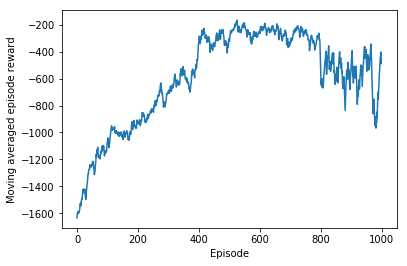

In [3]:
EP_MAX = 1000 # Number of episodes
EP_LEN = 200 # Length of a single episode
GAMMA = 0.9 # Discount factor
A_LR = 0.0001 # Actor learning rate
C_LR = 0.0002 # Critic learning rate
BATCH = 32 # Batch size
A_UPDATE_STEPS = 10 # Actor update steps
C_UPDATE_STEPS = 10 # Critic update steps
S_DIM = 3 # Number of states
A_DIM = 1 # Number of actions
METHOD = [
    dict(name='kl_pen', kl_target=0.01, lam=0.5),   # KL penalty
    dict(name='clip', epsilon=0.2),                 # Clipped surrogate objective, find this is better
][1]        # choose the method for optimization


class PPO(object):

    def __init__(self):
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32, [None, S_DIM], 'state')

        # critic
        with tf.variable_scope('critic'):
            l1 = tf.layers.dense(self.tfs, 32, tf.nn.relu)
            self.v = tf.layers.dense(l1, 1)
            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.advantage = self.tfdc_r - self.v
            self.closs = tf.reduce_mean(tf.square(self.advantage))
            self.ctrain_op = tf.train.AdamOptimizer(C_LR).minimize(self.closs)

        # actor
        pi, pi_params = self._build_anet('pi', trainable=True)
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(pi.sample(1), axis=0)       # choosing action
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.float32, [None, A_DIM], 'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate'):
                # ratio = tf.exp(pi.log_prob(self.tfa) - oldpi.log_prob(self.tfa))
                ratio = pi.prob(self.tfa) / oldpi.prob(self.tfa)
                surr = ratio * self.tfadv
            if METHOD['name'] == 'kl_pen':
                self.tflam = tf.placeholder(tf.float32, None, 'lambda')
                kl = tf.distributions.kl_divergence(oldpi, pi)
                self.kl_mean = tf.reduce_mean(kl)
                self.aloss = -(tf.reduce_mean(surr - self.tflam * kl))
            else:   # clipping method, find this is better
                self.aloss = -tf.reduce_mean(tf.minimum(
                    surr,
                    tf.clip_by_value(ratio, 1.-METHOD['epsilon'], 1.+METHOD['epsilon'])*self.tfadv))

        with tf.variable_scope('atrain'):
            self.atrain_op = tf.train.AdamOptimizer(A_LR).minimize(self.aloss)

        tf.summary.FileWriter("log/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

    def update(self, s, a, r):
        self.sess.run(self.update_oldpi_op)
        adv = self.sess.run(self.advantage, {self.tfs: s, self.tfdc_r: r})
        # adv = (adv - adv.mean())/(adv.std()+1e-6)     # sometimes helpful

        # update actor
        if METHOD['name'] == 'kl_pen':
            for _ in range(A_UPDATE_STEPS):
                _, kl = self.sess.run(
                    [self.atrain_op, self.kl_mean],
                    {self.tfs: s, self.tfa: a, self.tfadv: adv, self.tflam: METHOD['lam']})
                if kl > 4*METHOD['kl_target']:  # this in in google's paper
                    break
            if kl < METHOD['kl_target'] / 1.5:  # adaptive lambda, this is in OpenAI's paper
                METHOD['lam'] /= 2
            elif kl > METHOD['kl_target'] * 1.5:
                METHOD['lam'] *= 2
            METHOD['lam'] = np.clip(METHOD['lam'], 1e-4, 10)    # sometimes explode, this clipping is my solution
        else:   # clipping method, find this is better (OpenAI's paper)
            [self.sess.run(self.atrain_op, {self.tfs: s, self.tfa: a, self.tfadv: adv}) for _ in range(A_UPDATE_STEPS)]

        # update critic
        [self.sess.run(self.ctrain_op, {self.tfs: s, self.tfdc_r: r}) for _ in range(C_UPDATE_STEPS)]

    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            l1 = tf.layers.dense(self.tfs, 32, tf.nn.relu, trainable=trainable)
            mu = 2 * tf.layers.dense(l1, A_DIM, tf.nn.tanh, trainable=trainable)
            sigma = tf.layers.dense(l1, A_DIM, tf.nn.softplus, trainable=trainable)
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params

    def choose_action(self, s):
        s = s[np.newaxis, :]
        a = self.sess.run(self.sample_op, {self.tfs: s})[0]
        return np.clip(a, -2, 2)

    def get_v(self, s):
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v, {self.tfs: s})[0, 0]

env = gym.make('Pendulum-v0').unwrapped
ppo = PPO()
all_ep_r = []

for ep in range(EP_MAX):
    s = env.reset()
    buffer_s, buffer_a, buffer_r = [], [], []
    ep_r = 0
    for t in range(EP_LEN):    # in one episode
        # env.render()
        a = ppo.choose_action(s)
        s_, r, done, _ = env.step(a)
        buffer_s.append(s)
        buffer_a.append(a)
        buffer_r.append((r+8)/8)    # normalize reward, find to be useful
        s = s_
        ep_r += r

        # update ppo
        if (t+1) % BATCH == 0 or t == EP_LEN-1:
            v_s_ = ppo.get_v(s_)
            discounted_r = []
            for r in buffer_r[::-1]:
                v_s_ = r + GAMMA * v_s_
                discounted_r.append(v_s_)
            discounted_r.reverse()

            bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.array(discounted_r)[:, np.newaxis]
            buffer_s, buffer_a, buffer_r = [], [], []
            ppo.update(bs, ba, br)
    if ep == 0: all_ep_r.append(ep_r)
    else: all_ep_r.append(all_ep_r[-1]*0.9 + ep_r*0.1)
    print(
        'Ep: %i' % ep,
        "|Ep_r: %i" % ep_r,
        ("|Lam: %.4f" % METHOD['lam']) if METHOD['name'] == 'kl_pen' else '',
    )

# plt.style.use('dark_background')
plt.plot(np.arange(len(all_ep_r)), all_ep_r)
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()

# 初次编辑日期

2018年4月30日

# 参考文献

[1] Schulman, J., Wolski, F., Dhariwal, P., Radford, A. and Klimov, O., 2017. Proximal policy optimization algorithms. arXiv preprint arXiv:1707.06347.

[2] https://blog.openai.com/openai-baselines-ppo/